<a href="https://colab.research.google.com/github/lit2020/class-deep-learning/blob/main/%5BDL%5D201902656_%EA%B9%80%EA%B8%B0%EC%9B%85_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import torch
import torch.nn as nn # layers, loss functions
import torch.nn.functional as F # F.softmax

from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt
import random

# Cuda setting

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
random.seed(1214)
torch.manual_seed(1214)
if device == 'cuda':
    torch.cuda.manual_seed_all(1214)

cuda


# load dataset

In [ ]:
train_dataset =  torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset =  torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 88241360.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106259380.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30198157.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 686307.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Models

In [ ]:
class MLP_model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_model, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        self.layers = nn.ModuleList()
        self.activation = nn.Sigmoid()
        self.layers.append(nn.Linear(input_size, 512))
        # self.layers.append(nn.BatchNorm1d(512))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(512, 256))
        # self.layers.append(nn.BatchNorm1d(256))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(256, 128))
        # self.layers.append(nn.BatchNorm1d(128))
        self.layers.append(self.activation)
        self.layers.append(nn.MaxPool1d(3, padding=1, stride=2))
        # self.layers.append(self.activation)
        self.layers.append(nn.Linear(64, 32))
        # self.layers.append(self.activation)
        self.layers.append(nn.Linear(32, num_classes))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output

In [ ]:
class MLP_model_seq(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_model_seq, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        self.activation = nn.ReLU()
        self.layers = []
        self.layers.append(nn.Linear(input_size, 256))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(256, 128))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(128, 64))
        self.layers.append(self.activation)
        self.layers.append(nn.Linear(64, num_classes))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
class Cnn(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Cnn, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        # (1, 28, 28)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(1, 1, kernel_size=5, padding=2))# (1, 28, 28)
        self.layers.append(nn.Conv2d(1, 1, kernel_size=3, padding=1)) # (1, 28, 28)
        self.layers.append(nn.Conv2d(1, 1, kernel_size=3, stride=2)) # (1, 13, 13)
        self.layers.append(nn.MaxPool2d(2)) # (1, 12, 12)
        self.layers.append(nn.Flatten()) # (144)
        self.layers.append(nn.Linear(12 * 12, 128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(128, 128))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(128, 64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(64, num_classes))
        self.layers.append(nn.ReLU())

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output


# Hyper Parameters

In [ ]:
# parameters
input_size = 28 * 28
num_classes = 10
n_epochs = 30
learning_rate = 0.1

In [ ]:
batch_size = 100
train_loader= DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model Selection
#### learn only 1 cell

MLP model

In [ ]:
model = MLP_model(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

MLP model with nn.Sequential()



In [ ]:
model = MLP_model_seq(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

CNN model

In [ ]:
model= Cnn(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train

In [ ]:
loss_list = []
loss_train = []
for cnt_epoch in range(n_epochs):
    avg_cost = 0
    for cnt_batch, (x, y) in enumerate(train_loader):
        x = x.reshape(-1, 28 * 28)
        x_input = x.to(device)

        y_input = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x_input)
        loss = criterion(y_pred, y_input)
        loss.backward()
        optimizer.step()

        avg_cost += loss.item() / batch_size
        loss_list.append(loss)
    print("Epoch {} Loss {:.5f}".format(cnt_epoch + 1, avg_cost))
    loss_train.append(avg_cost)


Epoch 1 Loss 13.70194
Epoch 2 Loss 11.32274
Epoch 3 Loss 8.07341
Epoch 4 Loss 6.25804
Epoch 5 Loss 4.97841
Epoch 6 Loss 3.71324
Epoch 7 Loss 3.20591
Epoch 8 Loss 2.93395
Epoch 9 Loss 2.72072
Epoch 10 Loss 2.53944
Epoch 11 Loss 2.35217
Epoch 12 Loss 2.15472
Epoch 13 Loss 1.97155
Epoch 14 Loss 1.82066
Epoch 15 Loss 1.70373
Epoch 16 Loss 1.59983
Epoch 17 Loss 1.51038
Epoch 18 Loss 1.41051
Epoch 19 Loss 1.33163
Epoch 20 Loss 1.25244
Epoch 21 Loss 1.18328
Epoch 22 Loss 1.12287
Epoch 23 Loss 1.04694
Epoch 24 Loss 1.00692
Epoch 25 Loss 0.96010
Epoch 26 Loss 0.89902
Epoch 27 Loss 0.86834
Epoch 28 Loss 0.82241
Epoch 29 Loss 0.77910
Epoch 30 Loss 0.76306


# Plot Train Loss

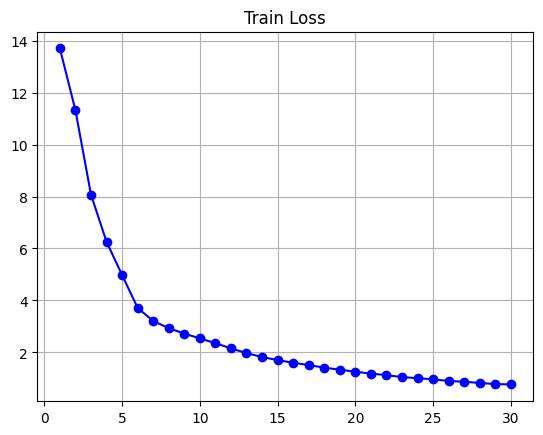

In [ ]:
plt.plot([i for i in range(1, n_epochs+1)], loss_train, 'bo-', label='Train Loss')
plt.grid()
plt.title("Train Loss")
plt.show()

# Validation

In [ ]:
with torch.no_grad():
    num_total_data = 0
    correct = 0
    for cnt_batch, (x, y) in enumerate(test_loader):
        x = x.reshape(-1, 28 * 28)
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        y_pred = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
        num_total_data += len(x)
        correct += sum(y == y_pred).item()

print("Model Accuracy : {:.5f}".format(correct / num_total_data))

Model Accuracy : 0.95420


# Model Summary

In [ ]:
for layer in model.children():
    print(layer)

ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Sigmoid()
  (6): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (7): Linear(in_features=32, out_features=10, bias=True)
)
Sigmoid()


In [ ]:
m = nn.Conv2d(1, 4, kernel_size=3, padding=1)
input = torch.randn(100, 4, 12, 12)
flat = nn.Flatten()
output = flat(input)

In [ ]:
m2 = nn.Conv2d(4, 2, kernel_size=5, padding=2)
output2 = m2(output)

In [ ]:
print(input.shape)
print(output.shape)

torch.Size([100, 4, 12, 12])
torch.Size([100, 576])


In [ ]:
pooling_layer = nn.MaxPool2d(3, stride=2)
output = pooling_layer(output)

In [ ]:
print(output.shape)

torch.Size([100, 4, 13, 13])


In [ ]:
# With Learnable Parameters
m = nn.BatchNorm1d(5)
input = torch.randn(3, 5)
output = m(input)


In [ ]:
print(input.shape)
print(output.shape)

torch.Size([3, 5])
torch.Size([3, 5])


In [ ]:
print(input)
print(output)
print(output[0])

tensor([[-1.0967,  0.4810, -1.5182, -0.5899,  0.0825],
        [-0.5428,  1.4874, -0.0942,  0.0334,  0.6678],
        [-0.8445,  1.1155,  0.2492, -0.9468,  0.0562]])
tensor([[-1.1866, -1.3164, -1.3903, -0.2192, -0.6600],
        [ 1.2594,  1.1057,  0.4707,  1.3195,  1.4131],
        [-0.0727,  0.2107,  0.9195, -1.1003, -0.7531]],
       grad_fn=<NativeBatchNormBackward0>)
tensor([-1.1866, -1.3164, -1.3903, -0.2192, -0.6600],
       grad_fn=<SelectBackward0>)


In [ ]:
print(sum(output[0]))
print(sum(input[0]))

tensor(-4.7725, grad_fn=<AddBackward0>)
tensor(-2.6413)


In [ ]:
print(nn.Linear(30, 32))

Linear(in_features=30, out_features=32, bias=True)
